In [1]:
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Put the analysis and plotting function in a
# python package, so they can be easily reused
from bayesian_stats_course_tools.analyse import analyse_data, plot_data

In [3]:
moon = "Europa"

t, distance, distance_alt, distance_err = np.loadtxt(
    f"../lectures/data/jovian_moons/{moon}.dat", unpack=True)

# Literature values
theta_true = dict(
    Io=[0.421700, 1.769*24, 2.935632897970926],
    Ganymede=[1.070400, 7.155*24, 1.5793369771861996],
    Europa=[0.671100, 3.551*24, 3.0779939041348796],
    Callisto=[1.882700, 16.689*24, 1.9374307501130097],
)

Text(0.5, 1.0, 'Europa')

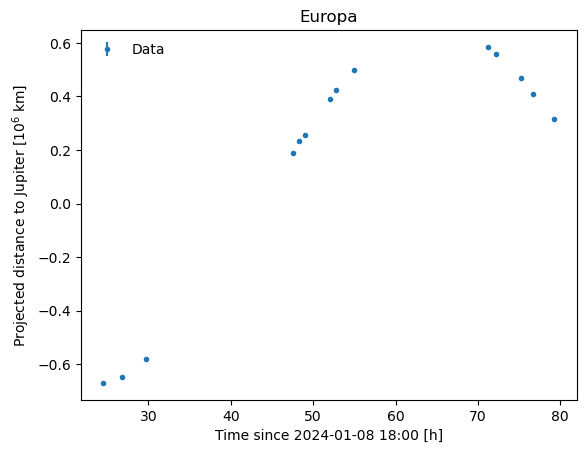

In [4]:
fig, ax = plot_data(
    x=t,
    y=distance,
    y_err=distance_err,
    linestyle="none",
    marker=".",
    axis_labels=["Time since 2024-01-08 18:00 [h]", "Projected distance to Jupiter [$10^6$ km]"],
)
ax.set_title(moon)

In [5]:

# Set up all the necessary functions in on go, based on a model for the mean,
# log_prior, and optional variance model:
def build_inference_model(model_fn, log_prior_fn=None, variance_model_fn=None):
    if log_prior_fn is None:
        log_prior_fn = lambda theta: 0

    if variance_model_fn is None:
        variance_model_fn = lambda sigma_y, theta, t: sigma_y**2
    
    def log_likelihood_fn(theta, t, sigma_y, y):
        mu = model_fn(theta, t)
        sigma2 = variance_model_fn(sigma_y, theta, t)
        return -0.5*len(y)*np.log(2*np.pi) - 0.5*np.sum(np.log(sigma2)) - np.sum(0.5 * (y - mu)**2/sigma2)
    
    def log_posterior_fn(theta, t, sigma_y, y):
        log_prior = log_prior_fn(theta)
        if not np.isfinite(log_prior):
            return -np.inf
        return log_likelihood_fn(theta, t, sigma_y, y) + log_prior

    def predict_fn(theta, x, sigma_y):
        mu = model_fn(theta, x)
        sigma2 = variance_model_fn(sigma_y, theta, t)
        return np.random.normal(loc=mu, scale=np.sqrt(sigma2))

    def ppd_test_statistic_fn(y, theta, t, sigma_y):
        mu = model_fn(theta, t)
        sigma2 = variance_model_fn(sigma_y, theta, t)
        return np.sum(0.5 * (y - mu)**2/sigma2)
    
    return log_posterior_fn, model_fn, predict_fn, ppd_test_statistic_fn

In [6]:
def base_model(theta, t):
    semimajor, period, phi = theta
    return semimajor * np.sin(2 * np.pi * t / period+phi)

MAP results
$a$_MAP = 0.67028653424488
$T$_MAP = 84.0793338260133
$\phi$_MAP = 3.0218819083375426


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:01<00:00, 2508.56it/s]


Auto-correlation time of chain:
$a$ = 40.4
$T$ = 42.2
$\phi$ = 44.3
PPD goodness of fit: 0.96 (T_rep = 6.9±2.6, (T_data = 2.1±1.3)
Posterior results (mean±std)
$a$ = 0.67±0.011
$T$ = 84±0.95
$\phi$ = 3±0.048
$M$ = 2e+27±1.2e+26


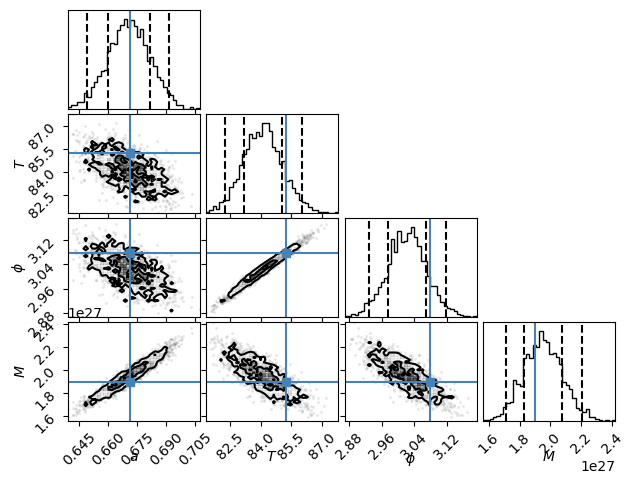

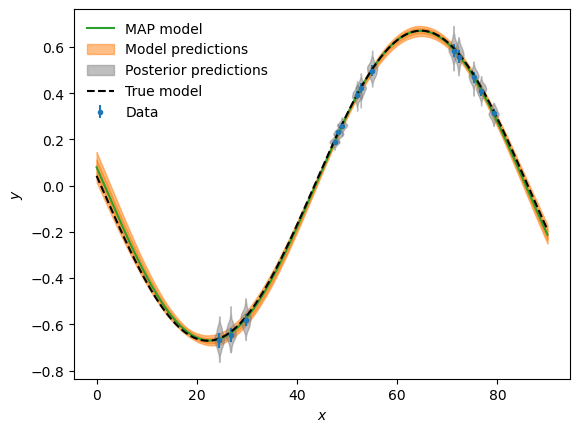

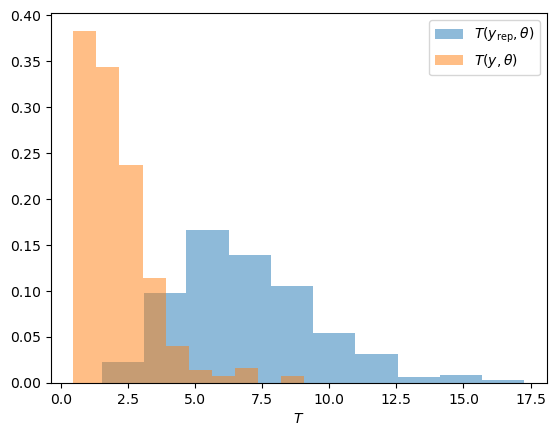

In [20]:
t_for_model = np.linspace(0, 90, 1000)

log_posterior, model, predict, ppd_test_statistic = build_inference_model(
    model_fn=base_model
)

# Inflate the uncertainty by the offset between the two distance estimates
distance_err_with_systematic = np.sqrt(distance_err**2 + (distance_alt-distance)**2)

data = dict(
    x=t, y=distance, y_err=distance_err_with_systematic
)

def mass_from_Kepler_3rd_law(theta):
    semimajor, period = theta[:2]
    return 4*(np.pi**2)/6.674e-11*((1e9*semimajor)**3)/((period*3600)**2)


results = analyse_data(
    data=data,
    log_posterior_fn=log_posterior,
    model_fn=model,
    predict_fn=predict,
    ppd_test_statistic_fn=ppd_test_statistic,
    param_names=["$a$", "$T$", "$\\phi$"],
    derived_parameter_fn=mass_from_Kepler_3rd_law,
    derived_parameter_names=["$M$"],
    derived_parameter_true=[1.8982e27],
    theta_true=theta_true[moon],
    theta_init=theta_true[moon],
    n_step_emcee=5000,
    model_x=t_for_model,
)

In [21]:
def plot_residuals(t, t_for_model, model_fn, distance, distance_err, results, true_model_fn, true_params):
    best_fit_model = model_fn(results["MAP"], t)
    best_fit_model_smooth = model_fn(results["MAP"], t_for_model)
    true_model_smooth = true_model_fn(true_params, t_for_model)

    model_quantiles = np.quantile(
        results["TPD"]-best_fit_model_smooth, q=[0.025, 0.16, 0.84, 0.975], axis=0
    )

    fig, ax = plot_data(
        x=t, y=distance-best_fit_model, y_err=distance_err,
        models=[
            dict(x=t_for_model, y=true_model_smooth-best_fit_model_smooth,
                style=dict(color="C3", ls="--", label="True model")),
            dict(x=t_for_model, lower=model_quantiles[0], upper=model_quantiles[-1],
                style=dict(color="C1", alpha=0.5, label="Model predictions")),
            dict(x=t_for_model, lower=model_quantiles[1], upper=model_quantiles[-2],
                style=dict(color="C1", alpha=0.5)),
            
            dict(x=t, violin_samples=results["PPD"] - best_fit_model,
                style=dict(color="grey", alpha=0.5, label="Posterior predictions")),
        ],
        marker=".", linestyle="none",
        axis_labels=["Time since 2024-01-08 18:00 [h]", "Residual projected distance to Jupiter [$10^6$ km]"],
    )
    ax.axhline(0, c="k", lw=1)


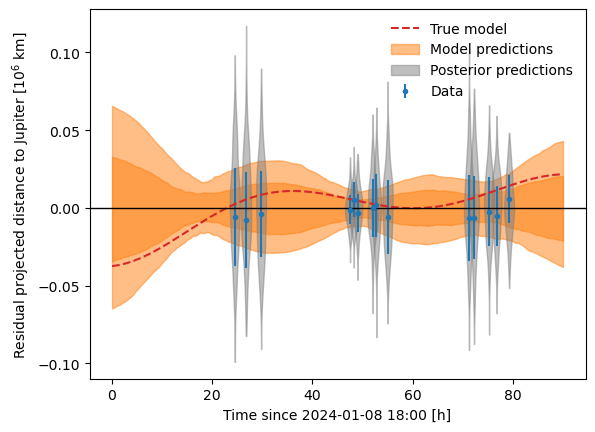

In [22]:

plot_residuals(
    t=t, t_for_model=t_for_model, model_fn=model,
    distance=distance, distance_err=distance_err_with_systematic,
    results=results, true_model_fn=base_model, true_params=theta_true[moon]
)

/Users/yooken/Codes/mambaforge/envs/stats_course_fs24/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/yooken/Codes/mambaforge/envs/stats_course_fs24/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


MAP results
$a$_MAP = 0.6710537194275068
$T$_MAP = 83.70965644499961
$\phi$_MAP = 3.0041422942012255
$a_\mathrm{sys}$_MAP = 0.0037699068360688725


  3%|▎         | 136/5000 [00:00<00:03, 1353.88it/s]

100%|██████████| 5000/5000 [00:02<00:00, 1815.07it/s]


Auto-correlation time of chain:
$a$ = 37.1
$T$ = 44.3
$\phi$ = 48.9
$a_\mathrm{sys}$ = 63.3
PPD goodness of fit: 0.54 (T_rep = 7.1±2.7, (T_data = 6.9±2.6)
Posterior results (mean±std)
$a$ = 0.67±0.0023
$T$ = 84±0.27
$\phi$ = 3±0.014
$a_\mathrm{sys}$ = 0.0051±0.0015
$M$ = 2e+27±2.7e+25


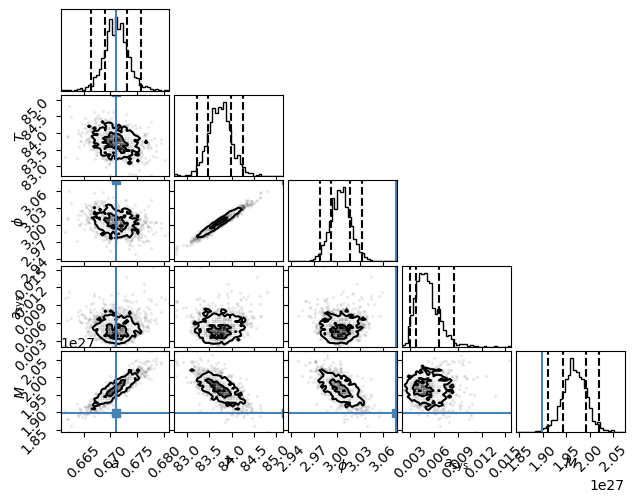

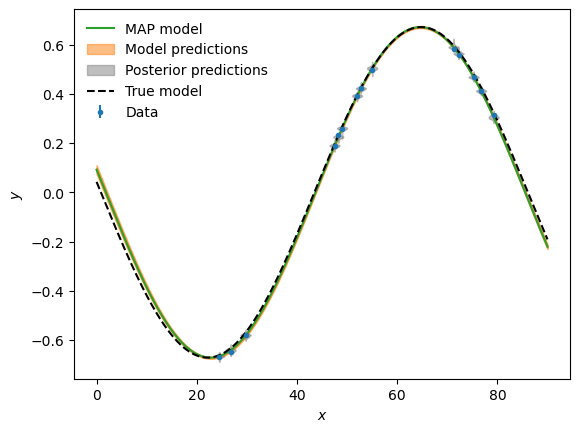

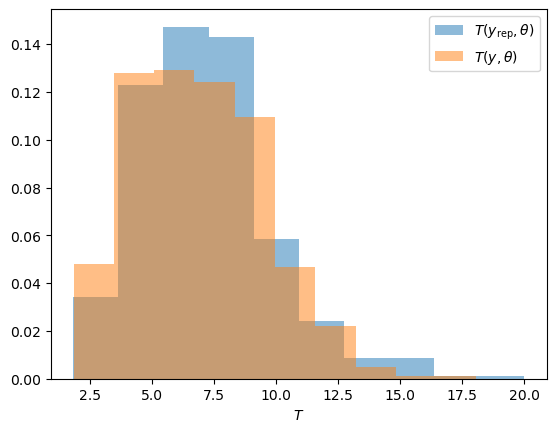

In [23]:
def sys_model(theta, t):
    semimajor, period, phi, a_sys = theta
    mu = base_model((semimajor, period, phi), t)
    return mu

def sys_variance_model(sigma_y, theta, t):
    semimajor, period, phi, a_sys = theta
    return sigma_y**2 + a_sys**2

def log_sys_model_prior(theta):
    semimajor, period, phi, a_sys = theta
    if a_sys < 0:
        return -np.inf
    else:
        return 0.0


log_posterior, model, predict, ppd_test_statistic = build_inference_model(
    model_fn=sys_model, log_prior_fn=log_sys_model_prior, variance_model_fn=sys_variance_model
)

data = dict(
    x=t, y=distance, y_err=distance_err
)

results = analyse_data(
    data=data,
    log_posterior_fn=log_posterior,
    model_fn=model,
    predict_fn=predict,
    ppd_test_statistic_fn=ppd_test_statistic,
    param_names=["$a$", "$T$", "$\\phi$", "$a_\\mathrm{sys}$"],
    derived_parameter_fn=mass_from_Kepler_3rd_law,
    derived_parameter_names=["$M$"],
    derived_parameter_true=[1.8982e27],
    theta_true=theta_true[moon] + [None],
    theta_init=theta_true[moon] + [0.01],
    n_step_emcee=5000,
    model_x=t_for_model,
)

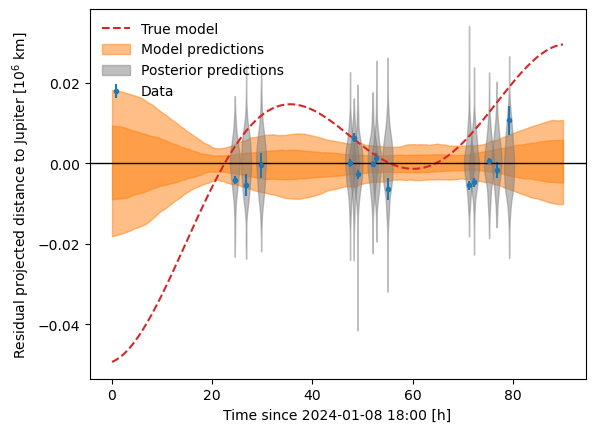

In [24]:
plot_residuals(
    t=t, t_for_model=t_for_model, model_fn=model,
    distance=distance, distance_err=distance_err,
    results=results, true_model_fn=base_model, true_params=theta_true[moon]
)